<a href="https://colab.research.google.com/github/DillonMurphy04/Data301Exam1/blob/main/DATA_301_Lab_6B_Dillon_Murphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bing Maps API

In this part of the lab, you will join the CityBikes data from the previous part of the lab with additional data that you will query from the Bing Maps API.

First, you will need to register for a Bing Maps Key. Follow the instructions [here](https://docs.microsoft.com/en-us/bingmaps/getting-started/bing-maps-dev-center-help/getting-a-bing-maps-key). You should be able to sign in with your Cal Poly account. When you get to Step 4, select:

- Key type: Basic
- Application type: Dev/Test

You will be able to make 125000 free requests with the resulting API key. This should be more than enough to complete this assignment.

We will be working with the [REST services in the Bing Maps API](https://docs.microsoft.com/en-us/bingmaps/rest-services/). Click on the link for a complete documentation of the features.

In [ ]:
import pandas as pd
import requests
import time
from pandas.io.json import json_normalize

## Question 1

Read in the `DataFrame` of bike stations in the United States from Part A of this lab. Restrict to the stations in the "Bay Wheels" network (with network ID "ford-gobike").

How many of these stations are in the city/county of San Francisco? 

(_Hint:_ Use the [Locations API](https://docs.microsoft.com/en-us/bingmaps/rest-services/locations/) to get the address associated with each latitude and longitude coordinate.)

In [ ]:
df_stations = pd.read_csv("/content/USbike.csv", index_col = 0)
df_stations.head()

,empty_slots,free_bikes,id,latitude,longitude,name,timestamp,extra.address,extra.altitude,extra.ebikes,...,extra.payment-terminal,extra.renting,extra.returning,extra.slots,extra.uid,extra.post_code,extra.bike_uids,extra.number,network_id,city
0,13,0,2b0452ef99fa25ce9db62a8c9bb917aa,39.364081,-107.034000,Basalt BRT Downvalley,2023-02-27T04:38:30.331000Z,Basalt,0.0,0.0,...,False,1.0,1.0,13.0,1433,NaN,NaN,NaN,we-cycle,"Aspen, CO"
1,7,0,63cf805d373b399ae1daa391373d7a42,39.387865,-107.083800,Triangle Park,2023-02-27T04:38:30.303000Z,Basalt,0.0,0.0,...,False,1.0,1.0,7.0,1420,NaN,NaN,NaN,we-cycle,"Aspen, CO"
2,7,0,2ccb7b9041a6901cc76e92983e61cd9d,39.386449,-107.083000,Willits Town Center,2023-02-27T04:38:30.334000Z,Basalt,0.0,0.0,...,False,1.0,1.0,7.0,1439,NaN,NaN,NaN,we-cycle,"Aspen, CO"
3,11,0,5fe55b6d158e753930aba287b87e0836,39.392904,-107.089598,El Jebel BRT Upvalley,2023-02-27T04:38:30.330000Z,Basalt,0.0,0.0,...,False,1.0,1.0,11.0,1432,81623.0,NaN,NaN,we-cycle,"Aspen, CO"
4,7,0,d4e64b89339be8aafa37203a16957568,39.399257,-107.090126,JW Dr | El Jebel Rd,2023-02-27T04:38:30.338000Z,Basalt,0.0,0.0,...,False,1.0,1.0,7.0,1474,81623.0,NaN,NaN,we-cycle,"Aspen, CO"


In [ ]:
df_bay = df_stations[df_stations["network_id"] == "bay-wheels"]

In [ ]:
loc = []
for lon, lat in zip(df_bay["longitude"], df_bay["latitude"]):
  resp = requests.get(
      "http://dev.virtualearth.net/REST/v1/Locations/%s,%s?key=Atgq4YJGbnPloaBdrPugAw8dWkvkZbDxJpEsvHRy0oTIiiHIBobNw650Gx6P4Een" % (lat, lon)
  )
  loc.extend(resp.json()["resourceSets"][0]["resources"])
  time.sleep(0.5)

In [ ]:
locations = pd.json_normalize(loc)

In [ ]:
len(locations[locations["address.adminDistrict2"] == "San Francisco Co."])

293

293 of the bike stations in the US in the "Bay Wheels" network are in the county of San Francisco.

## Question 2

You want to go to Coit Tower. To save money, you decide to ride a "Bay Wheels" bike to the closest station and hail a cab from there to Coit Tower. What station should you bike to so that you are as close to Coit Tower as possible (as measured by driving distance)? Does your answer agree with the one that you obtained in Part A of this lab? If not, why does it differ?

_Hints:_ 
- You should restrict your attention to bike stations that are in San Francisco, which you determined in Question 1. 
- Use the [Routes API](https://docs.microsoft.com/en-us/bingmaps/rest-services/routes/calculate-a-distance-matrix) to calculate a distance matrix between Coit Tower and the bike stations. 
- You can do this with just one call to the API. Because there are too many stations, it is impossible to specify all the locations in the URL. Instead, you should make a POST request (`requests.post`), passing in the parameters as a JSON object through the `json=` parameter of `requests.post`. Read the API documentation carefully to learn how to use the POST API.

In [ ]:
SF = locations[locations["address.adminDistrict2"] == "San Francisco Co."]

In [ ]:
url = "https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?key=Atgq4YJGbnPloaBdrPugAw8dWkvkZbDxJpEsvHRy0oTIiiHIBobNw650Gx6P4Een"

headers = {
    "Content-Type": "application/json",
}

origins = [{"latitude": i[0], "longitude": i[1]} for i in SF["point.coordinates"]]

data = {
    "origins": origins,
    "destinations": [{
        "latitude": 37.8024,
        "longitude": -122.4058
    }],
    "travelMode": "driving"
}
response = requests.post(url, headers=headers, json=data)

resp = response.json()
resp

{'authenticationResultCode': 'ValidCredentials',
 'brandLogoUri': 'http://dev.virtualearth.net/Branding/logo_powered_by.png',
 'copyright': 'Copyright © 2023 Microsoft and its suppliers. All rights reserved. This API cannot be accessed and the content and any results may not be used, reproduced or transmitted in any manner without express written permission from Microsoft Corporation.',
 'resourceSets': [{'estimatedTotal': 1,
   'resources': [{'__type': 'DistanceMatrix:http://schemas.microsoft.com/search/local/ws/rest/v1',
     'destinations': [{'latitude': 37.8024, 'longitude': -122.4058}],
     'origins': [{'latitude': 37.763155, 'longitude': -122.426629},
      {'latitude': 37.76704458, 'longitude': -122.3908335},
      {'latitude': 37.778965, 'longitude': -122.4370983},
      {'latitude': 37.7838917, 'longitude': -122.3988083},
      {'latitude': 37.731809, 'longitude': -122.450984},
      {'latitude': 37.804427, 'longitude': -122.403045},
      {'latitude': 37.771674, 'longitude':

In [ ]:
distance = pd.json_normalize(resp["resourceSets"][0]["resources"][0]["results"])
distance.head()

,destinationIndex,originIndex,totalWalkDuration,travelDistance,travelDuration
0,0,0,0,6.787,20.5333
1,0,1,0,6.752,20.4833
2,0,2,0,5.754,16.0167
3,0,3,0,3.783,13.6167
4,0,4,0,13.301,24.3667


In [ ]:
distance.iloc[distance["travelDistance"].idxmin()]

destinationIndex       0.0000
originIndex          204.0000
totalWalkDuration      0.0000
travelDistance         0.9620
travelDuration         3.2333
Name: 204, dtype: float64

In [ ]:
SF.iloc[204]["name"]

'710 Lombard St, San Francisco, CA 94133, United States'

In [ ]:
SF[SF["address.intersection.baseStreet"] == "Sansome St"]['address.formattedAddress']

5    1500 Sansome St, San Francisco, CA 94111, Unit...
Name: address.formattedAddress, dtype: object

My answer does not agree with my answer from part A of this lab. In part A I got the address 1500 Sansome St, San Francisco, CA 94111, however in part B I got 710 Lombard St, San Francisco, CA 94133, United States. The difference is likely due to how distance is calculated. In the distance matrix, as by the routes API documentation "The distances and times returned are based on the routes calculated by the Bing Maps Route API. Times are based on predictive traffic information, depending on the start time specified in the request. Distance matrices can be calculated for driving, walking and public transit routes." Thus, although the calculation of manhattan distance from The Embarcadero at Sansome St may be closer, the driving distance based on predicted traffic and actual SF roads is closer for 710 Lombard St. Since there are not really any direct roads from the Embarcadero to Coit tower, but there are from Lombard St, this makes a lot of sense. (Even though it looks closer on the map)

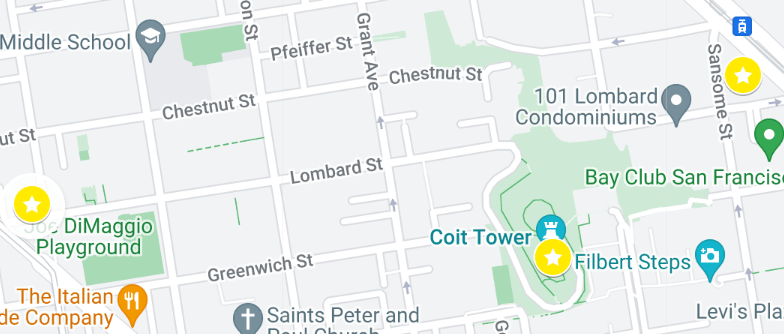

## Submission Instructions

- Copy this notebook to your own Drive, if you have not already.
- Restart this notebook and run the cells from beginning to end. 
  - Go to Runtime > Restart and Run All.
- Rename this notebook by clicking on "DATA 301 Lab 6B - YOUR NAMES HERE" at the very top of this page. Replace "YOUR NAMES HERE" with the first and last names of you (and your partners, for Phase 2).
- Get the link to your notebook:
  - Click on "Share" at the top-right. 
  - Change the settings to "Anyone with the link can view". 
  - Copy the sharing link into Canvas.